In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

<h1>Get Dataset</h1>

In [2]:
# read csv file
df = pd.read_csv(r'predictive_maintenance.csv', index_col='Product ID')

In [3]:
df.head()

,UDI,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
Product ID,,,,,,,,,
M14860,1,M,298.1,308.6,1551,42.8,0,0,No Failure
L47181,2,L,298.2,308.7,1408,46.3,3,0,No Failure
L47182,3,L,298.1,308.5,1498,49.4,5,0,No Failure
L47183,4,L,298.2,308.6,1433,39.5,7,0,No Failure
L47184,5,L,298.2,308.7,1408,40.0,9,0,No Failure


<h1>Data Preprocessing</h1>

In [4]:
df.drop(['UDI'], axis=1, inplace=True)

In [5]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
Product ID,,,,,,,,
M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [6]:
# check nulls for dataset
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [7]:
df.Type.unique()

array(['M', 'L', 'H'], dtype=object)

In [8]:
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

Dataset is extremely skewed. 0 represents no failure, 1 represents failure

In [9]:
df["Failure Type"].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [10]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

Some values are marked incorrectly. After studying the CSV file, it is seen that Some Random Failures have been marked as 0 in Target when they should be marked as 1. And some failures where Target is marked as 1 (failure), Failure Type has been marked as 'No Failure'. We will correctly mark them

In [11]:
df.loc[(df['Failure Type']=='Random Failures'), 'Target']=1

In [12]:
df.loc[((df['Target']==1) & (df['Failure Type']=='No Failure')), 'Failure Type']='Random Failures'

In [13]:
df.Target.value_counts()

0    9643
1     357
Name: Target, dtype: int64

In [14]:
df['Failure Type'].value_counts()

No Failure                  9643
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               27
Name: Failure Type, dtype: int64

Now no. of failures in Target and 'No Failure' in Failure Type match

In [15]:
le = preprocessing.LabelEncoder()
le.fit(df['Type'])
df['Type'] = le.transform(df['Type'])

In [16]:
le.fit(df['Failure Type'])
df['Failure Type'] = le.transform(df['Failure Type'])
df['Failure Type'].unique()

array([1, 3, 5, 2, 4, 0])

In [17]:
df_corr = df.corr()['Target'].sort_values(ascending=False).drop(['Target', 'Failure Type'])
df_corr.head(10)

Torque [Nm]                0.190050
Tool wear [min]            0.104671
Air temperature [K]        0.084217
Process temperature [K]    0.039965
Type                      -0.010045
Rotational speed [rpm]    -0.045769
Name: Target, dtype: float64

In [18]:
df_corr = df.corr()['Failure Type'].sort_values(ascending=False).drop(['Target', 'Failure Type'])
df_corr.head(10)

Tool wear [min]            0.109688
Rotational speed [rpm]     0.076111
Torque [Nm]                0.032085
Process temperature [K]   -0.003570
Type                      -0.006484
Air temperature [K]       -0.023521
Name: Failure Type, dtype: float64

Text(0.5, 42.0, 'Machine Maintenance Predictive data')

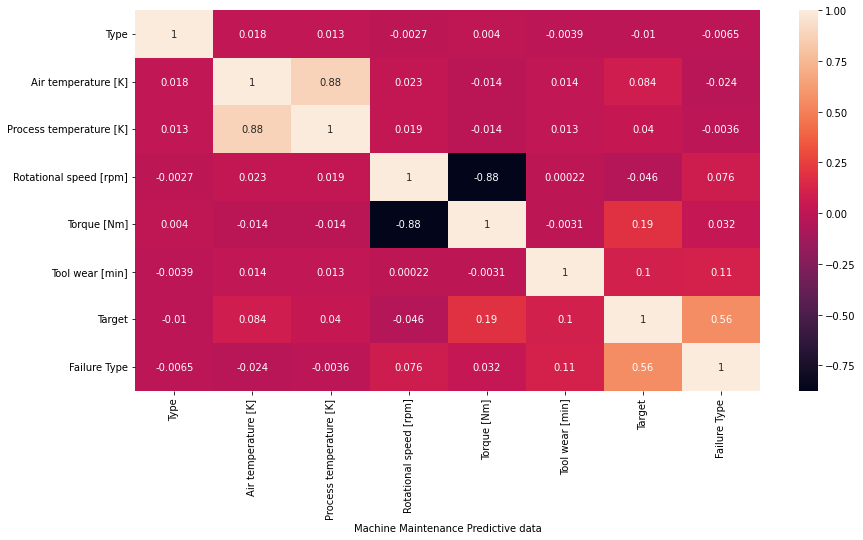

In [19]:
plt.figure(figsize=(14,7))
corr = df.corr() #correlation of each column to one another
# Heatmap of said correlation
sns.heatmap(corr, annot=True)

# Add label for horizontal axis
plt.xlabel("Machine Maintenance Predictive data")

Air temperature [K] and Process temperature [K] are highly correlated. This is expected as in the description of this dataset, the following is mentioned:
<ul>
    <li>air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K</li>
    <li>process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.</li>
</ul>

Failure Type and Target have a high correlation because we can have a valid failure type if the machine fails in the first place

In [20]:
col_names = ["Air temperature [K]","Process temperature [K]"]
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df[col_names] = features

In [21]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
Product ID,,,,,,,,
M14860,2,-0.952389,-0.947360,1551,42.8,0,0,1
L47181,1,-0.902393,-0.879959,1408,46.3,3,0,1
L47182,1,-0.952389,-1.014761,1498,49.4,5,0,1
L47183,1,-0.902393,-0.947360,1433,39.5,7,0,1
L47184,1,-0.902393,-0.879959,1408,40.0,9,0,1


In [22]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df.loc[:,"Air temperature [K]" :"Process temperature [K]"])
pca_X = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2'])


In [23]:
df = df.reset_index()

In [24]:
df = df.join(pca_X)

In [25]:
df.drop(['Air temperature [K]','Process temperature [K]'], axis=1, inplace=True)

In [26]:
df = df.set_index("Product ID")

Text(0.5, 42.0, 'Machine Maintenance Predictive data')

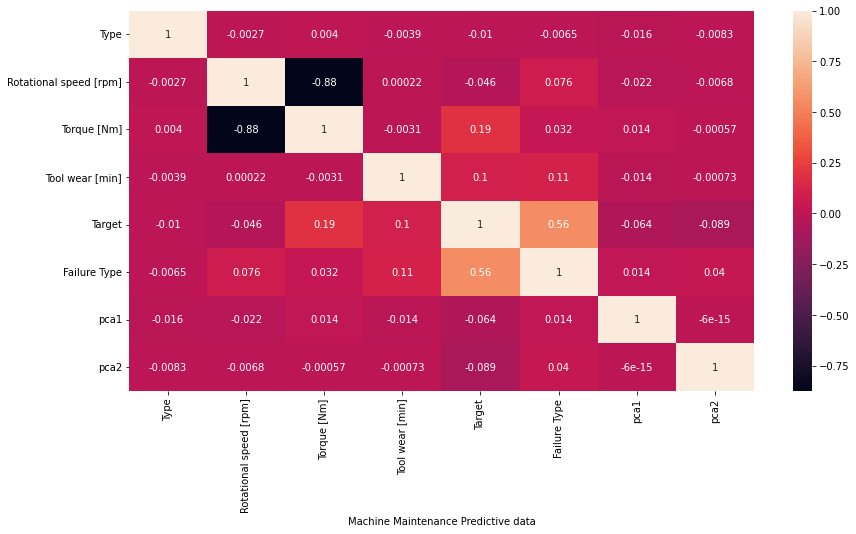

In [27]:
plt.figure(figsize=(14,7))
corr = df.corr() #correlation of each column to one another
# Heatmap of said correlation
sns.heatmap(corr, annot=True)

# Add label for horizontal axis
plt.xlabel("Machine Maintenance Predictive data")

In [28]:
df.head()

,Type,Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,pca1,pca2
Product ID,,,,,,,,
M14860,2,1551,42.8,0,0,1,1.343326,0.003556
L47181,1,1408,46.3,3,0,1,1.260313,0.015864
L47182,1,1498,49.4,5,0,1,1.390985,-0.044103
L47183,1,1433,39.5,7,0,1,1.307973,-0.031796
L47184,1,1408,40.0,9,0,1,1.260313,0.015864


<h1>Modelling</h1>

In [29]:
y_features = ['Target','Failure Type']
y = df[y_features]

In [30]:
df_train, df_test, y_train, y_test = train_test_split(df.drop(y_features, axis=1), df[y_features], test_size=0.20, random_state=42, shuffle = True, stratify = y)

In [31]:
pipe_lr = Pipeline(steps=[('lr_multi',MultiOutputClassifier(LogisticRegression()))])

In [32]:
pipe_lr.fit(df_train, y_train)

c:\users\mroy\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
c:\users\mroy\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

Pipeline(steps=[('lr_multi',
                 MultiOutputClassifier(estimator=LogisticRegression()))])

In [33]:
pipe_lr.score(df_train,y_train)

0.96325

Training set score is 96.3%

In [34]:
pipe_lr.score(df_test,y_test)

0.964

Test score is 96.4%

In [35]:
y_pred = pd.DataFrame(pipe_lr.predict(df_test))
y_pred

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
1995,0,1
1996,0,1
1997,0,1
1998,0,1


In [36]:
y_test

,Target,Failure Type
Product ID,,
L53705,1,3
M24814,0,1
M19733,0,1
L54426,0,1
L50027,0,1
...,...,...
H31955,0,1
L53070,0,1
L53474,0,1


In [37]:
matrix_Target = confusion_matrix(y_test['Target'], y_pred[0])

In [38]:
print('Confusion matrix : \n',matrix_Target)

Confusion matrix : 
 [[1929    0]
 [  70    1]]


In [39]:
muxc = pd.MultiIndex.from_product([['Predicted Values'], ['No Failure', 'Failure']])
muxi = pd.MultiIndex.from_product([['Actual Values'], ['No Failure', 'Failure']])

df_mat_target = pd.DataFrame(matrix_Target, columns = muxc, index = muxi)
df_mat_target

Predicted Values        
                               No Failure Failure
Actual Values No Failure             1929       0
              Failure                  70       1

In [40]:
matrix_FailureType = confusion_matrix(y_test['Failure Type'], y_pred[1], labels=[0,1,2,3,4,5])

In [41]:
print('Confusion matrix : \n',matrix_FailureType)

Confusion matrix : 
 [[   0   21    1    0    0    0]
 [   0 1928    1    0    0    0]
 [   0   11    5    0    0    0]
 [   0   19    0    0    0    0]
 [   0    5    0    0    0    0]
 [   0    8    1    0    0    0]]


In [42]:
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
le_name_list = [None]*len(le_name_mapping)
for key in le_name_mapping:
    le_name_list[key] = le_name_mapping[key]
le_name_list

['Heat Dissipation Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failures',
 'Tool Wear Failure']

In [43]:
muxc = pd.MultiIndex.from_product([['Predicted Values'], le_name_list])
muxi = pd.MultiIndex.from_product([['Actual Values'], le_name_list])

df_mat_failuretype = pd.DataFrame(matrix_FailureType, columns = muxc, index = muxi)
df_mat_failuretype

Predicted Values             \
                                       Heat Dissipation Failure No Failure   
Actual Values Heat Dissipation Failure                        0         21   
              No Failure                                      0       1928   
              Overstrain Failure                              0         11   
              Power Failure                                   0         19   
              Random Failures                                 0          5   
              Tool Wear Failure                               0          8   

                                                                         \
                                       Overstrain Failure Power Failure   
Actual Values Heat Dissipation Failure                  1             0   
              No Failure                                1             0   
              Overstrain Failure                        5             0   
              Power Failure                             0             0   
              Random Failures                           0             0   
              Tool Wear Failure                         1             0   

                                                                          
                                       Random Failures Tool Wear Failure  
Actual Values Heat Dissipation Failure               0                 0  
              No Failure                             0                 0  
              Overstrain Failure                     0                 0  
              Power Failure                          0                 0  
              Random Failures                        0                 0  
              Tool Wear Failure                      0                 0